In [57]:
# 참고: https://godongyoung.github.io/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2019/02/11/Mahalanobis-and-MCD.html

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm.csv')

analy_col = [ 'CycleTime', 'VpPosition', 'VpTime',
       'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
       'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
       'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
       'Zone1', 'Zone2', 'Zone3', 'Zone4']

analy_df = isee_machine[analy_col]
scaled_X = RobustScaler().fit_transform(analy_df)
scaled_df = pd.DataFrame(scaled_X, columns=analy_col)

In [19]:
# True_label >  정상/비정상
y = isee_machine_operation['NG5']

In [20]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)

In [21]:
# features_to_select = 5
selector = RFE(clf, n_features_to_select = 5, step=1)
selector = selector.fit(X_scaler, y)

In [22]:
rfe_cols = list(cols[selector.support_.tolist()])
rfe_cols

['CycleTime', 'VpTime', 'PlasticsEndPosotion', 'ClampingTime', 'TankTemp']

In [21]:
import random
n = 5000   # 랜덤으로 n개 추출
randIdx = random.sample(range(len(scaled_df)), n)

In [ ]:
import import_ipynb
import isee_def

tsne_result, plots = isee_def.draw_tsne(scaled_df.values, isee_machine_operation['CycleNum'].values, randIdx)

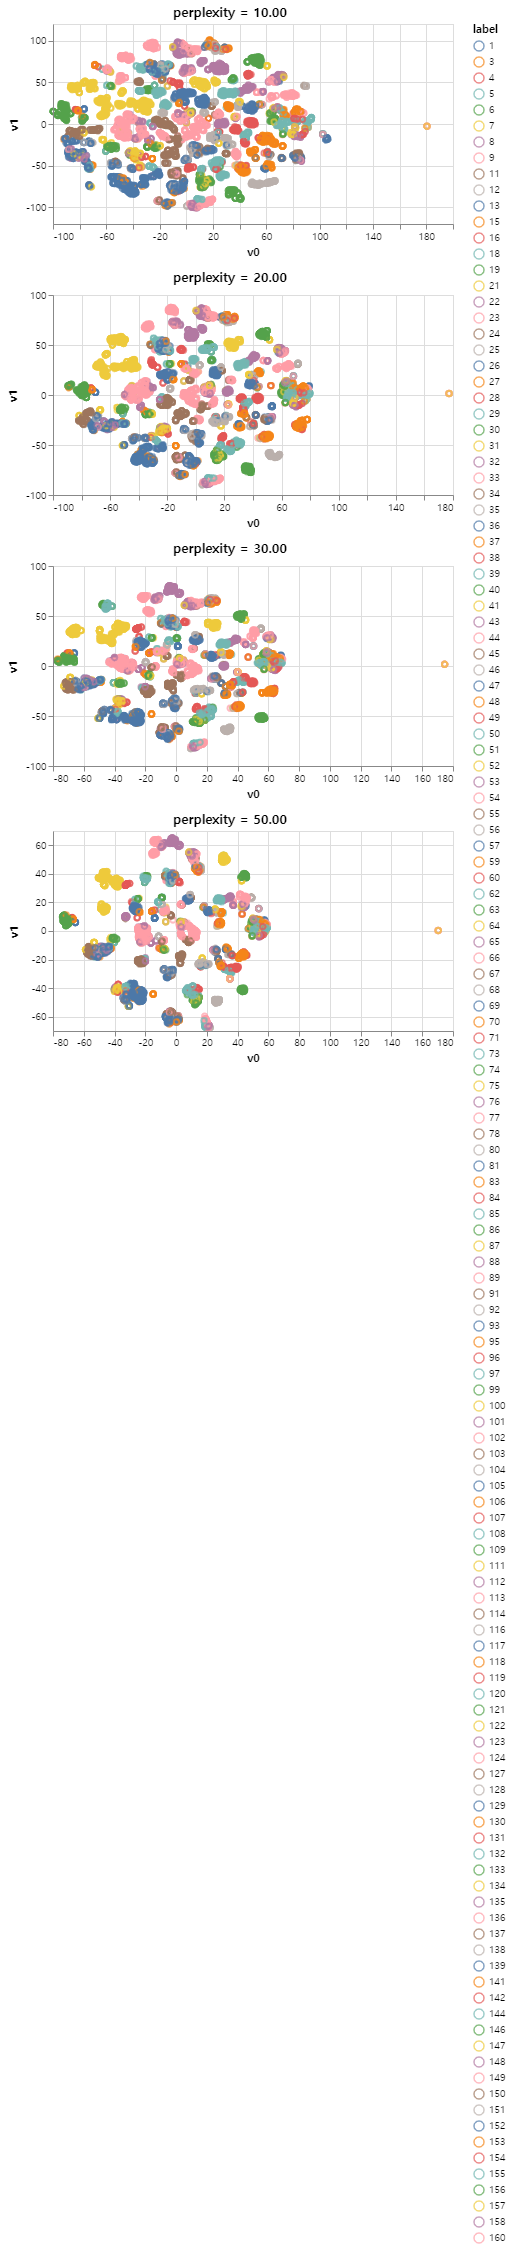

In [28]:
alt.vconcat(plots[0],plots[1],plots[2],plots[3])

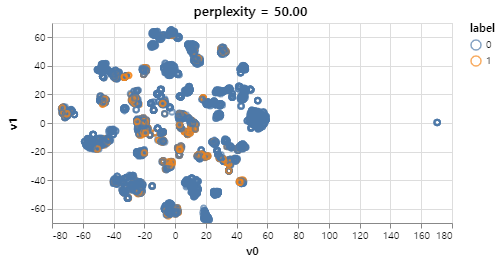

In [43]:
perplexity = 50
df_tsne_result = (pd.DataFrame(tsne_result[perplexity], columns=['v0','v1']).assign())
df_tsne_result['label']= isee_machine_operation['NG5'].values[randIdx]

base = alt.Chart(df_tsne_result).encode(x='v0:Q',y='v1:Q', color='label:N').properties(width=400, height=200, title='perplexity = {:.2f}'.format(perplexity))    
mark = base.mark_point()
chart = mark
chart

### Mahalanobis distance(MD)

In [31]:
from sklearn.neighbors import DistanceMetric

In [32]:
dist = DistanceMetric.get_metric('mahalanobis', V=np.cov(X_scaler[randIdx]))

In [33]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(X_scaler)
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(X_scaler)

In [34]:
np.min(m), np.mean(m), np.max(m)

(5.8835783326371365, 1543.6427826667493, 46797798.66703261)

In [35]:
m.shape

(235300,)

In [50]:
mahala_label = pd.DataFrame([0 if x< 280 else 1 for x in m])
isee_machine_operation['mahala_label'] = mahala_label.values

In [129]:
################################################################################## HDBSCAN
import hdbscan

hdbs = hdbscan.HDBSCAN(min_cluster_size=80, allow_single_cluster=True, metric='manhattan')
hdbs.fit(X_scaler)

predict_hdb = pd.DataFrame(hdbs.labels_, index=isee_machine_operation.index)
predict_hdb.columns= ['predict_HDB']

print('총 ', len(np.unique(hdbs.labels_)), ' 개의 군집!')
################################################################################## 

총  102  개의 군집!


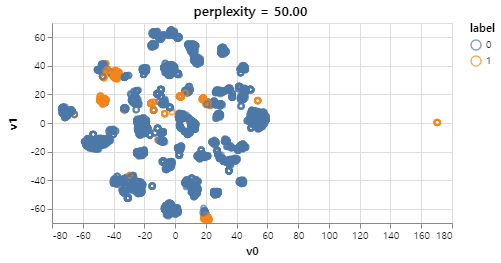

In [51]:
perplexity = 50
df_tsne_result = (pd.DataFrame(tsne_result[perplexity], columns=['v0','v1']).assign())
df_tsne_result['label']= mahala_label.values[randIdx]

base = alt.Chart(df_tsne_result).encode(x='v0:Q',y='v1:Q', color='label:N').properties(width=400, height=200, title='perplexity = {:.2f}'.format(perplexity))    
mark = base.mark_point()
chart = mark
chart

In [195]:
np.unique(isee_machine_operation[isee_machine_operation['True_label']=='Y']['mahala_label'])

array([0, 1], dtype=int64)

In [54]:
isee_machine_operation[isee_machine_operation['NG5']==1].shape

(27455, 28)

In [56]:
isee_machine_operation[(isee_machine_operation['NG5']==1) & (isee_machine_operation['mahala_label']==1)].shape

(2154, 28)